In [60]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
import re
import contractions
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import Perceptron
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import warnings
import gensim.downloader as api
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import precision_recall_fscore_support as score


In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
stopWords=set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /Users/anudeep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anudeep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/anudeep/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
SEED = 42

In [4]:
dataset = pd.read_csv('./datasets/fraud_email_.csv')

In [5]:
dataset.shape

(11929, 2)

In [6]:
len(dataset[dataset['Class'] == 1]), len(dataset[dataset['Class'] == 0])

(5187, 6742)

In [7]:
dataset

,Text,Class
0,Supply Quality China's EXCLUSIVE dimensions at...,1
1,over. SidLet me know. Thx.,0
2,"Dear Friend,Greetings to you.I wish to accost ...",1
3,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....,1
4,Not a surprising assessment from Embassy.,0
...,...,...
11924,Travel well. I'll look forward to hearing your...,0
11925,"Dear friend, I wish to begin by way of introdu...",1
11926,Follow Up Flag: Follow upFlag Status: FlaggedM...,0
11927,sbwhoeop B6Saturday January 23 2010 4:09 PMRe:...,0


## Pre-processing data

In [8]:
def remove_contractions(text):
    words = []
    for word in text.split():  
        words.append(contractions.fix(word))
    res = ' '.join(words)
    return res

def dataCleaning(text):
    text=str(text)
    text=text.lower()
    # Remove non-alphabetical characters and extra spaces
    text = remove_contractions(text)
    text = re.sub(r'\.', ' . ', text)
    text = re.sub(r'\,', ' , ', text)
    text = re.sub(r'\:', ' : ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words=[]
     # Perform contractions
    return text

def removestopwords(text):
    words=text.split(' ')
    words = [word for word in words if word not in stopWords]    
    text = ' '.join(words)
    return text

def performlemmatization(text):
    lemmatizer = WordNetLemmatizer()
    
    words=text.split(' ')
    words = [lemmatizer.lemmatize(word) for word in words]    
    text = ' '.join(words)
    return text

def add_space_for_punctuations(text):
    # This regular expression captures:
    # 1. A word (\w+)
    # 2. A punctuation character ([.,!?])
    pattern = re.compile(r'(\w+)([.,!?])')
    result = pattern.sub(r'\1 \2', text)
    return result

In [9]:
dataset["email_body_clean"] = dataset["Text"].apply(dataCleaning)
dataset["email_body_clean"] = dataset["email_body_clean"].apply(removestopwords)
# dataset["email_body_clean"] = dataset["email_body_clean"].apply(add_space_for_punctuations)
# dataset["email_body_clean"] = dataset["email_body_clean"].apply(performlemmatization)

In [10]:
dataset

,Text,Class,email_body_clean
0,Supply Quality China's EXCLUSIVE dimensions at...,1,supply quality china's exclusive dimensions un...
1,over. SidLet me know. Thx.,0,. sidlet know . thanks .
2,"Dear Friend,Greetings to you.I wish to accost ...",1,"dear friend , greetings . wish accost request ..."
3,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....,1,mr . cheung puihang seng bank ltd . des voeux ...
4,Not a surprising assessment from Embassy.,0,surprising assessment embassy .
...,...,...,...
11924,Travel well. I'll look forward to hearing your...,0,travel well . look forward hearing report .
11925,"Dear friend, I wish to begin by way of introdu...",1,"dear friend , wish begin way introduction . wi..."
11926,Follow Up Flag: Follow upFlag Status: FlaggedM...,0,follow flag : follow upflag status : flaggedmo...
11927,sbwhoeop B6Saturday January 23 2010 4:09 PMRe:...,0,sbwhoeop b6saturday january 23 2010 4 : 09 pmr...


### Run models using TFIDF as features

In [11]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(dataset["email_body_clean"])
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_features, dataset['Class'].to_numpy(), 
                                                                test_size=0.5, random_state=SEED)

count_vectorizer = CountVectorizer()
count_features = count_vectorizer.fit_transform(dataset["email_body_clean"])

X_train_count, X_test_count, _, _ = train_test_split(count_features, dataset['Class'].to_numpy(), 
                                                                test_size=0.5, random_state=SEED)


In [164]:
def print_scores(y_test, y_predtest):
    precision = precision_score(y_test, y_predtest,average="macro")
    recall = recall_score(y_test, y_predtest,average="macro")
    f1 = f1_score(y_test, y_predtest,average="macro")
    accuracy = accuracy_score(y_test, y_predtest)
    print(precision,recall,f1,accuracy)
    
    cm =confusion_matrix(y_test, y_predtest)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    print("precision for 1 - ", TP/(TP+FP), "Recall for 1 - ",TP/(TP+FN))
    print(TP+FN,sum(y_test))
    y_test_inv = [ abs(i-1) for i in y_test]
    y_predtest_inv = [ abs(i-1) for i in y_predtest]
    
    cm =confusion_matrix(y_test_inv, y_predtest_inv)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    print(TP+FN,sum(y_test))
    print("precision for 0 - ", TP/(TP+FP), "Recall for 0 - ",TP/(TP+FN))
    

In [13]:
sum(y_test), len(y_test), sum(y_train), len(y_train)

(2585, 5965, 2602, 5964)

In [14]:
X_train_tfidf.shape, X_test_tfidf.shape

((5964, 110912), (5965, 110912))

In [15]:
SVM_tfidf = LinearSVC(C=1.0)
SVM_tfidf.fit(X_train_tfidf, y_train)
ypredtest_svm_tfidf = SVM_tfidf.predict(X_test_tfidf)
ypredtest_svm_tfidf.shape

(5965,)

In [16]:
SVM_count = LinearSVC(C=1.0)
SVM_count.fit(X_train_count, y_train)
ypredtest_svm_count = SVM_count.predict(X_test_count)
ypredtest_svm_count.shape

(5965,)

In [17]:
perceptron_tfidf = Perceptron()
perceptron_tfidf.fit(X_train_count, y_train)
ypredtest_perceptron = perceptron_tfidf.predict(X_test_count)
ypredtest_perceptron.shape

(5965,)

In [18]:
print("SVM with TFIDF:")
print_scores(y_test, ypredtest_svm_tfidf)

SVM with TFIDF:
0.9988090512107979 0.9733075435203095 0.9858934169278997 0.987929589270746


In [19]:
print("SVM with count:")
print_scores(y_test, ypredtest_svm_count)

SVM with count:
0.9928853754940712 0.9717601547388781 0.9822091886608015 0.9847443419949706


In [20]:
print("Perceptron with count:")
print_scores(y_test, ypredtest_perceptron)

Perceptron with count:
0.9725400457665904 0.9864603481624759 0.9794507393892836 0.9820620284995809


In [21]:
########## TEST The Model with Other datasets ##########

In [22]:
iswda_dataset = pd.read_csv('./datasets/IWSPA-AP-Parsed.csv')

In [23]:
iswda_dataset

,email_from,email_to,email_subject,email_body,is_phishing
0,"""eBay""<aw-confirm@ebay.com>",undisclosed-recipients:;,Account On-hold: Please confirm your eBay info...,Message sent trough eBay System Your registere...,1
1,"""eBay Priority Protection"" <unpaid@eBay.com>",user@domain.com,Alert eBay Unpaid Item Strike Received,<!-- style2 {color: #0000CC} --> Alert eBay Un...,1
2,"""Jenn Crabtree"" <Jenn.Crabtree@alz.org>",undisclosed-recipients:;,Aknowledge The Receipt Of the Mail,A Computer Database Maintainance is currently ...,1
3,"""E-gold""<AccSecRobot_noreplay@e-gold.com>",undisclosed-recipients:;,Notification of limited account access,"We recently reviewed your e-gold account, and ...",1
4,"""Simon John Rubias Dela Cruz"" <SimonJohn@dls.c...",undisclosed-recipients:;,KEEPING TRACK OF YOUR USAGE.,Your web mail quota has exceeded the set quota...,1
...,...,...,...,...,...
10291,NaN,NaN,NaN,"body,#bodyTable,#bodyCell{ height:100% !import...",0
10292,NaN,NaN,NaN,Donald Trump on Thursday fired back at Paul Ry...,0
10293,NaN,NaN,NaN,Let me know if you have any edits Alex Shapiro...,0
10294,NaN,NaN,NaN,By Henry C. Jackson | 04/25/2016 05:43 PM EDT ...,0


In [24]:
iswda_dataset["email_body_clean"] = iswda_dataset["email_body"].apply(dataCleaning)
iswda_dataset["email_body_clean"] = iswda_dataset["email_body_clean"].apply(removestopwords)

In [145]:
iswda_dataset

,email_from,email_to,email_subject,email_body,is_phishing,email_body_clean
0,"""eBay""<aw-confirm@ebay.com>",undisclosed-recipients:;,Account On-hold: Please confirm your eBay info...,Message sent trough eBay System Your registere...,1,message sent trough ebay system registered nam...
1,"""eBay Priority Protection"" <unpaid@eBay.com>",user@domain.com,Alert eBay Unpaid Item Strike Received,<!-- style2 {color: #0000CC} --> Alert eBay Un...,1,<!-- style2 {color : #0000cc} --> alert ebay u...
2,"""Jenn Crabtree"" <Jenn.Crabtree@alz.org>",undisclosed-recipients:;,Aknowledge The Receipt Of the Mail,A Computer Database Maintainance is currently ...,1,computer database maintainance currently going...
3,"""E-gold""<AccSecRobot_noreplay@e-gold.com>",undisclosed-recipients:;,Notification of limited account access,"We recently reviewed your e-gold account, and ...",1,"recently reviewed e-gold account , suspect acc..."
4,"""Simon John Rubias Dela Cruz"" <SimonJohn@dls.c...",undisclosed-recipients:;,KEEPING TRACK OF YOUR USAGE.,Your web mail quota has exceeded the set quota...,1,web mail quota exceeded set quota 3gb . curren...
...,...,...,...,...,...,...
10291,NaN,NaN,NaN,"body,#bodyTable,#bodyCell{ height:100% !import...",0,"body , #bodytable , #bodycell{ height : 100% !..."
10292,NaN,NaN,NaN,Donald Trump on Thursday fired back at Paul Ry...,0,donald trump thursday fired back paul ryan say...
10293,NaN,NaN,NaN,Let me know if you have any edits Alex Shapiro...,0,let know edits alex shapiro mid atlantic & pac...
10294,NaN,NaN,NaN,By Henry C. Jackson | 04/25/2016 05:43 PM EDT ...,0,henry c . jackson | 04/25/2016 05 : 43 pm edt ...


In [26]:
tfidf_features_iswa = tfidf_vectorizer.transform(iswda_dataset["email_body_clean"])


In [28]:
testLabels = iswda_dataset['is_phishing'].to_numpy()
ypred_iswda_svm_tfidf = SVM_tfidf.predict(tfidf_features_iswa)
ypred_iswda_svm_tfidf.shape

(10296,)

In [29]:
print("SVM with TFIDF Test:")
print_scores(testLabels, ypred_iswda_svm_tfidf)

SVM with TFIDF Test:
0.46528403967538323 0.4558303886925795 0.4605087014725569 0.8825757575757576


In [31]:
dataset

,Text,Class,email_body_clean
0,Supply Quality China's EXCLUSIVE dimensions at...,1,supply quality china's exclusive dimensions un...
1,over. SidLet me know. Thx.,0,. sidlet know . thanks .
2,"Dear Friend,Greetings to you.I wish to accost ...",1,"dear friend , greetings . wish accost request ..."
3,MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....,1,mr . cheung puihang seng bank ltd . des voeux ...
4,Not a surprising assessment from Embassy.,0,surprising assessment embassy .
...,...,...,...
11924,Travel well. I'll look forward to hearing your...,0,travel well . look forward hearing report .
11925,"Dear friend, I wish to begin by way of introdu...",1,"dear friend , wish begin way introduction . wi..."
11926,Follow Up Flag: Follow upFlag Status: FlaggedM...,0,follow flag : follow upflag status : flaggedmo...
11927,sbwhoeop B6Saturday January 23 2010 4:09 PMRe:...,0,sbwhoeop b6saturday january 23 2010 4 : 09 pmr...


## Using Word2Vec features

In [34]:
wv = api.load('word2vec-google-news-300')

In [41]:
def get_word2vec_features(data):
    master=[]
    for index, row in data.iterrows():
        sentence = row['email_body_clean']
        words=sentence.split(' ')
        sentence_vector=[]
        for word in words:
            sentence_vector.append(wv[word] if word in wv else np.zeros(300))
        master.append(np.mean(sentence_vector, axis=0))
    return np.array(master)

In [42]:
train_master = get_word2vec_features(dataset)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train_master, dataset['Class'].to_numpy(), test_size=0.2, random_state=45)

In [44]:
# SVM model
svm_model = LinearSVC(C=1.0)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print("Precision (Word2Vec) - SVM:",precision,"Recall (Word2Vec) - SVM:",recall,"F1 (Word2Vec) - SVM:",f1)
print("Accuracy (Word2Vec) - SVM:", accuracy_svm)



Precision (Word2Vec) - SVM: 0.9767206477732794 Recall (Word2Vec) - SVM: 0.9405458089668616 F1 (Word2Vec) - SVM: 0.9582919563058591
Accuracy (Word2Vec) - SVM: 0.9647946353730092


In [47]:
# Test features
test_features_iswda = get_word2vec_features(iswda_dataset)
testLabels = iswda_dataset['is_phishing'].to_numpy()
ypred_iswda_svm = svm_model.predict(test_features_iswda)
ypred_iswda_svm.shape

(10296,)

In [49]:
print("SVM with TFIDF Test:")
print_scores(testLabels, ypred_iswda_svm)

SVM with TFIDF Test:
0.45468202303455185 0.8021201413427562 0.580377117289869 0.8724747474747475


In [56]:
'''
P = TP / TP + FP
R = TP / TP + FN
'''
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
confusion_mat = confusion_matrix(testLabels, ypred_iswda_svm, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=svm_model.classes_)

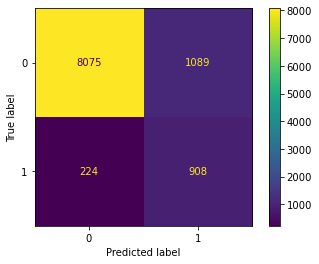

In [58]:
disp.plot()
plt.show()

In [53]:
svm_model.classes_

array([0, 1])

## GRU Model

In [133]:
def predict(model, dataloader):
    prediction_list = []
    for data, target in dataloader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1) 
        prediction_list.extend(list(np.array(predicted.cpu())))
    return prediction_list

In [71]:
max([len(x) for x in dataset['email_body_clean'].str.split()])

7870

In [76]:
sum([len(x) for x in dataset['email_body_clean'].str.split()]) / dataset['email_body_clean'].shape[0]

123.94878028334311

In [97]:
class SimpleGRU(nn.Module):
    def __init__(self):
        super(SimpleGRU, self).__init__()
        self.GRU = nn.GRU(300, 100, batch_first=True)
        self.fc = nn.Linear(100, 2)100`````
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.GRU(x)
        out = self.fc(out[:, -1, :])
        return out
# initialize the NN
model = SimpleGRU()
print(model)

SimpleGRU(
  (GRU): GRU(300, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)


In [98]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = torch.tensor(self.features[index], dtype=torch.float32)
        label = torch.tensor(self.labels[index], dtype=torch.long) 
        return feature, label


In [137]:
def get_rnn_features(data):
    master=[]
    for index, row in data.iterrows():
        sentence = row['email_body_clean']
        words=sentence.split(' ')
        sentence_vector=[]
        for word in words[:100]:
            sentence_vector.append(wv[word] if word in wv else np.zeros(300))
        if len(sentence_vector)<100:
            for i in range(100-len(sentence_vector)):
                sentence_vector.append(np.zeros(300))
        master.append(sentence_vector)
    return np.array(master)

In [138]:
train_master = get_rnn_features(dataset)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(train_master, dataset['Class'].to_numpy(), test_size=0.1, random_state=45)

In [101]:
train_data = CustomDataset(features=X_train, labels=np.array(y_train))

In [128]:
test_data=CustomDataset(features=X_test, labels=np.array(y_test))

In [129]:
# loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [130]:
num_workers = 0
# the number of samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers,)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [131]:
# Test features
test_master = get_rnn_features(iswda_dataset)
testLabels = iswda_dataset['is_phishing'].to_numpy()
test_data=CustomDataset(features=test_master, labels=testLabels)
test_iswda_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

10736

In [165]:
# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model 
    
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
        
    # validate the model 
    
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # printing training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    preds = predict(model, test_loader)
    print("Accuracy scores on validation data :")
    print_scores(y_test, preds)

    ypred_iswda_gru = predict(model, test_iswda_loader)
    print("Accuracy scores on iwsda data :")
    print_scores(testLabels, ypred_iswda_gru)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss,
        ))
    
    # saving the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Accuracy scores on validation data :
0.981901328469163 0.979114627887083 0.980385485015866 0.980720871751886
precision for 1 -  0.990234375 Recall for 1 -  0.9657142857142857
525 525
668 525
precision for 0 -  0.973568281938326 Recall for 0 -  0.9925149700598802
Accuracy scores on iwsda data :
0.6489123832113621 0.8176078463429644 0.6648926916280815 0.7828282828282829
precision for 1 -  0.3193717277486911 Recall for 1 -  0.8621908127208481
1132 1132
9164 1132
precision for 0 -  0.9784530386740331 Recall for 0 -  0.7730248799650807
Epoch: 1 	Training Loss: 0.020530 	Validation Loss: 0.009622
Validation loss decreased (inf --> 0.009622).  Saving model ...
Accuracy scores on validation data :
0.981901328469163 0.979114627887083 0.980385485015866 0.980720871751886
precision for 1 -  0.990234375 Recall for 1 -  0.9657142857142857
525 525
668 525
precision for 0 -  0.973568281938326 Recall for 0 -  0.9925149700598802
Accuracy scores on iwsda data :
0.6472624719586426 0.8159164452080888 0.662

KeyboardInterrupt: 

In [141]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [144]:
print_scores(testLabels, ypred_iswda_gru)
accuracy = accuracy_score(testLabels, ypred_iswda_gru)

0.33537284894837477 0.7747349823321554 0.46810781958900455 0.8064296814296814
